[Title - Edit?]
# Pop-Up Course: Better metal forming by linking experiment, modeling, and process control  
#### July 29-30, 2019

## Monte Carlo Grain Growth Simulation

[Introduction] + theory 

[Code Intro/Algo] explaination

In [73]:
# Import required libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython import display
import time

# Inline Plots
%matplotlib inline

Functions to Cal

Make a 2D square lattice:

In [74]:
nlp = 100  # number of lattice points
N = (nlp + 1) * (nlp + 1)
Q = N  # Number of states in Q-state potts model
X = np.linspace(0, 1, nlp + 1)
x, y = np.meshgrid(X, X)

Functions:

In [75]:
"""
 Function definitions
"""

def createNeighborStateMatrix(i, j,state):
    Jm1=j-1
    Jp1=j+1
    Im1=i-1
    Ip1=i+1
    
    # Periodic Boundary Condition
    if(i==0):
        Im1=len(state)-1
    if(i==len(state)-1):
        Ip1=0        
    if(j==0):
        Jm1=len(state)-1
    if(j==len(state)-1):
        Jp1=0
    # 3x3 matrix of state all cells surrounding current lattice point
    neighborStateMatrix = np.array([[state[Im1, Jm1], state[Im1, j], state[Im1, Jp1]],
                           [state[i, Jm1], state[i, j], state[i, Jp1]],
                           [state[Ip1, Jm1], state[Ip1, j], state[Ip1, Jp1]]])
    return neighborStateMatrix


def calculateKroneckerDelta(neighborStateMatrix):
    kd = np.zeros([1, 8])
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[0, 0]):
        kd[0, 0] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[0, 1]):
        kd[0, 1] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[0, 2]):
        kd[0, 2] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[1, 2]):
        kd[0, 3] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[2, 2]):
        kd[0, 4] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[2, 1]):
        kd[0, 5] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[2, 0]):
        kd[0, 6] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[1, 0]):
        kd[0, 7] = 1
    return sum(sum(kd))


def changeState(neighborStateMatrix):
    neighborI=1
    neighborJ=1
    
    while (neighborI==1) and (neighborJ==1):
        neighborI=np.random.randint(3)
        neighborJ=np.random.randint(3)
        neighborStateMatrix[1,1]=neighborStateMatrix[neighborI,neighborJ];
    return  neighborStateMatrix


Matrices initialized:

In [76]:
state = np.random.randint(Q, size=(x.shape))
colormatrix = np.random.rand(Q, 3)
neighborStateMatrix = np.zeros([3, 3])

# Boundary detection
isinside = np.ones(shape=(x.shape))
for i in range(0, nlp + 1):
    for j in range(0, nlp + 1):
        if (i == 0) or (j == 0) or (i == nlp) or (j == nlp):
            isinside[i,j] = 0

**MCS Loop Starts here:**

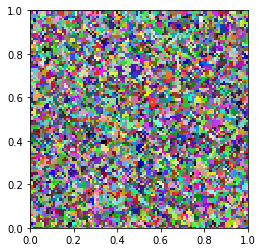

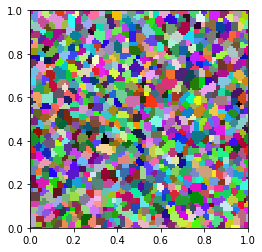

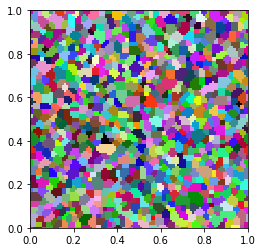

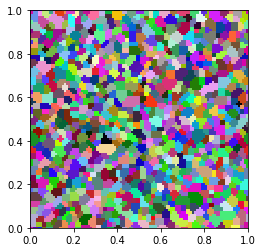

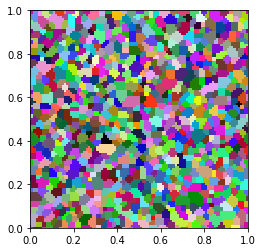

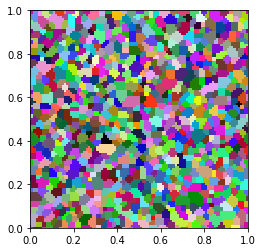

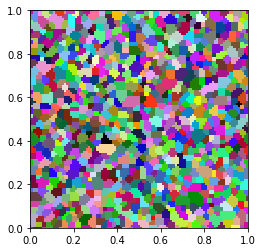

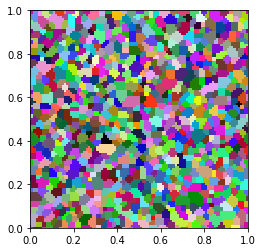

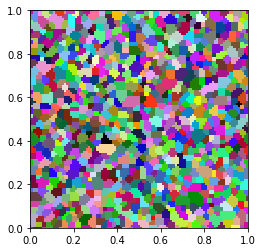

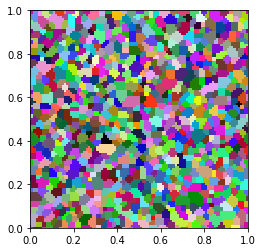

In [77]:
for mcs in range(0,100):
    for n in range(0, N):
        # Pick random lattice cite
        i = np.random.randint(0, len(x))
        j = np.random.randint(0, len(x))
        neighborStateMatrix = createNeighborStateMatrixBoundary(i, j, state)
        energyBeforeChange = 8-calculateKroneckerDelta(neighborStateMatrix)
        neighborStateMatrix=changeState(neighborStateMatrix)
        energyAfterChange = 8-calculateKroneckerDelta(neighborStateMatrix)
        dE=energyAfterChange-energyBeforeChange
        if dE<0:
            state[i,j]=neighborStateMatrix[1,1]
    # Plotting as squares
    if (mcs%10.0==0):
        fig, ax = plt.subplots(1)
        for i in range(0, nlp + 1):
           for j in range(0, nlp + 1):
               rect = patches.Rectangle((x[i, j]-(0.5 / nlp), y[i, j]-(0.5 / nlp)), 1.0 / nlp, 1.0 / nlp,linewidth=1, edgecolor='none', facecolor=colormatrix[state[i, j], :])
               ax.add_patch(rect)
        plt.gca().set_aspect('equal', adjustable='box')
        display.display(plt.gcf())
        display.clear_output(wait=True)